In [7]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import sklearn 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline 

In [2]:
sns.set_theme(context = 'notebook', style = 'darkgrid')

In [3]:
df = pd.read_csv(ZipFile("data/GoodReads_100k_books.csv.zip").open('GoodReads_100k_books.csv'))

In [4]:
df.head()

,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings
0,Laurence M. Hauptman,Hardcover,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,002914180X,9.78E+12,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33
1,"Charlotte Fiell,Emmanuelle Dirix",Paperback,Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,1906863482,9.78E+12,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41
2,Andy Anderson,Paperback,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,948984147,9.78E+12,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26
3,Carlotta R. Anderson,Hardcover,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,814327079,9.78E+12,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6
4,Jean Leveille,NaN,"Aujourdâ€™hui, lâ€™oiseau nous invite Ã sa ta...",NaN,https://i.gr-assets.com/images/S/compressed.ph...,2761920813,NaN,https://goodreads.com/book/show/10010880-les-o...,177,4.00,1,Les oiseaux gourmands,1


<h2>Prepare Data</h2>

In [5]:
df = df.dropna(subset = ['desc', 'genre'])

In [18]:
df['genres'] = df.genre.apply(lambda s: str(s).split(","))

In [9]:
df['desc_cleaned'] = df.desc.str.lower()

In [32]:
df.genres.apply(len).mean(), df.genres.apply(len).median()

(9.369795870620576, 10.0)

[Text(0.5, 1.0, 'Histogram of the Number of Categories Per Book'),
 Text(0.5, 0, 'Number of Categories'),
 Text(0, 0.5, 'Density')]

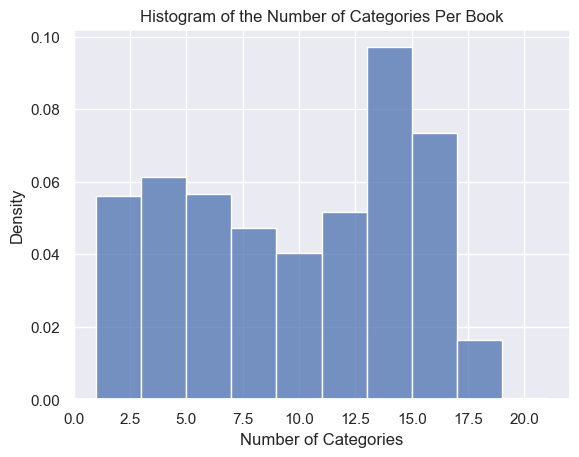

In [60]:
f = sns.histplot(df.genres.apply(len), stat = 'density', binwidth = 2)
f.set(title = 'Histogram of the Number of Categories Per Book', xlabel = 'Number of Categories', 
      ylabel = 'Density')

In [31]:
all_genres = df.explode("genres")

<h3>See Distribution of Classes</h3>

In [58]:
genre_counts = all_genres.genres.value_counts()

In [59]:
genre_counts.mean(), genre_counts.median()

(9149.82, 5874.5)

[Text(0.5, 1.0, 'Log Distribution'), Text(0.5, 0, 'Log Number of Occurences')]

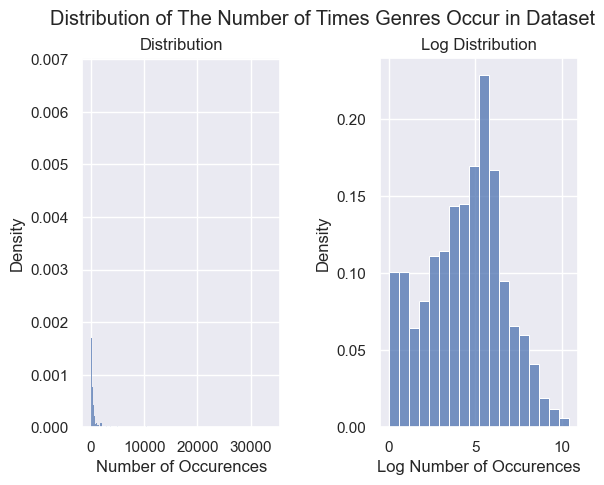

In [39]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

f1 = sns.histplot(genre_counts, stat = 'density', ax = ax[0])
f2 = sns.histplot(np.log(genre_counts), stat = 'density', ax = ax[1])

f.suptitle('Distribution of The Number of Times Genres Occur in Dataset')
f1.set(title = 'Distribution', xlabel = 'Number of Occurences')
f2.set(title = 'Log Distribution', xlabel = 'Log Number of Occurences')

In [40]:
top_genres = genre_counts.sort_values(ascending = False)[:50]

<h3>Remove Uncommon Classes</h3>

In [46]:
all_genres = all_genres[all_genres.apply(lambda s: s.genres in top_genres.index, axis = 1)]

Text(0, 0.5, 'Frequency')

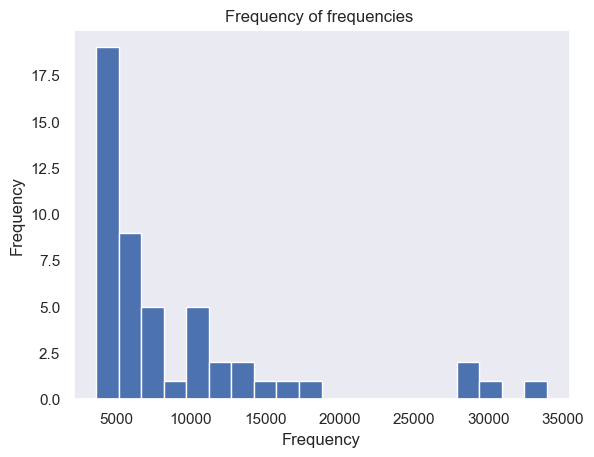

In [51]:
# display the changed frequencies in a new histogram: 
ax = all_genres['genres'].value_counts().hist(grid=False,bins=20)
ax.set_title("Frequency of frequencies ")
ax.set_xlabel("Frequency")
ax.set_ylabel("Frequency")

In [44]:
x = all_genres['desc']
y = all_genres['genres']

<h2>Reduce Label Dimensions</h2>

In [43]:
genre_counts.shape[0]

1179

In [ ]:
x_test, y_test, x_train, y_train = train_test_split(x, y, random_state = 42, stratify = y) 

In [ ]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(x_test.values)

X_counts.shape

In [ ]:
X_counts

In [ ]:
tf = TfidfTransformer(use_idf = False)
X_tf = tf.transform(X_counts)

X_tf.shape

In [ ]:
svd = TruncatedSVD(n_components = 100, random_state = 42)
X_transform = svd.fit_transform(X_tf)

In [ ]:
svd.explained_variance_.sum()

In [ ]:
X = admit.drop(['Chance of Admit', 'admitted'], axis = 1)
X_scaled = scale(X)
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X)

<h2>Text Processing</h2>

In [ ]:
shuffle = StratifiedShuffleSplit(y, test_size = 0.8, random_state = 42)

In [ ]:
for train_index, test_index in shuffle:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
tf = TfidfTransformer(use_idf = False).fit_transform(X_counts)
X_tf.shape